<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
# suffix = "_StaticOptimization_activation"
suffix = "_StaticOptimization_force"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,hand_r_s2h_Fz,hand_r_s2h_Tx,hand_r_s2h_Ty,hand_r_s2h_Tz,filename,participant,men,height,mass,n_trial
0,0.00,23.652682,27.068302,3.979502,3.697904,52.109265,33.563627,5.172502,0.780755,57.929688,...,-0.509577,-0.014216,-0.080315,0.048916,VerCF6H2_3,verc,0,2,6,3
1,0.01,27.103029,46.883440,7.304265,6.887965,61.815737,41.055890,6.142475,0.831296,56.984085,...,-3.762791,-0.017499,-0.347744,-0.041224,VerCF6H2_3,verc,0,2,6,3
2,0.02,25.942840,61.592794,9.931953,8.130907,62.690593,40.130939,5.821917,0.733874,52.537777,...,-8.603951,-0.042062,-0.682239,0.034615,VerCF6H2_3,verc,0,2,6,3
3,0.03,29.718247,83.423054,14.057985,9.485969,75.032962,44.275561,6.191048,0.708320,51.026888,...,-16.761802,0.004343,-1.295435,-0.100997,VerCF6H2_3,verc,0,2,6,3
4,0.04,31.283189,99.406429,18.045941,10.075401,84.024922,46.352642,6.023002,0.715177,51.110945,...,-24.206840,0.052452,-1.810190,-0.128836,VerCF6H2_3,verc,0,2,6,3


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(act)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [6]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
act = act.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(act)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


### Drop unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,VerCF6H2_3,verc,0,2,6,3,0.00,LVS,23.652682
1,VerCF6H2_3,verc,0,2,6,3,0.01,LVS,27.103029
2,VerCF6H2_3,verc,0,2,6,3,0.02,LVS,25.942840
3,VerCF6H2_3,verc,0,2,6,3,0.03,LVS,29.718247
4,VerCF6H2_3,verc,0,2,6,3,0.04,LVS,31.283189


In [8]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_r_s2h_Fx",
    "hand_r_s2h_Fy",
    "hand_r_s2h_Fz",
    "hand_r_s2h_Tx",
    "hand_r_s2h_Ty",
    "hand_r_s2h_Tz",
]

act_melt = act_melt.query("variable != @blacklist")

In [9]:
# gh_muscles = [
#     "DELT1",
#     "DELT2",
#     "DELT3",
#     "INFSP",
#     "LAT",
#     "PECM1",
#     "PECM2",
#     "PECM3",
#     "SUBSC",
#     "SUPSP",
#     "TMAJ",
#     "TMIN",
#     "CORB",
# ]
# act_melt = act_melt.query("variable == @gh_muscles")

## Description

In [10]:
print(
    f"value > 0.999 = {act_melt.query('value > 0.999').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value > 0.999 = 94.42%


In [11]:
x = act_melt.groupby(["variable", "index"])["value"].mean().reset_index()
x.head()

,variable,index,value
0,CORB,0.00,3.729171
1,CORB,0.01,3.161532
2,CORB,0.02,3.278719
3,CORB,0.03,3.311550
4,CORB,0.04,3.394280


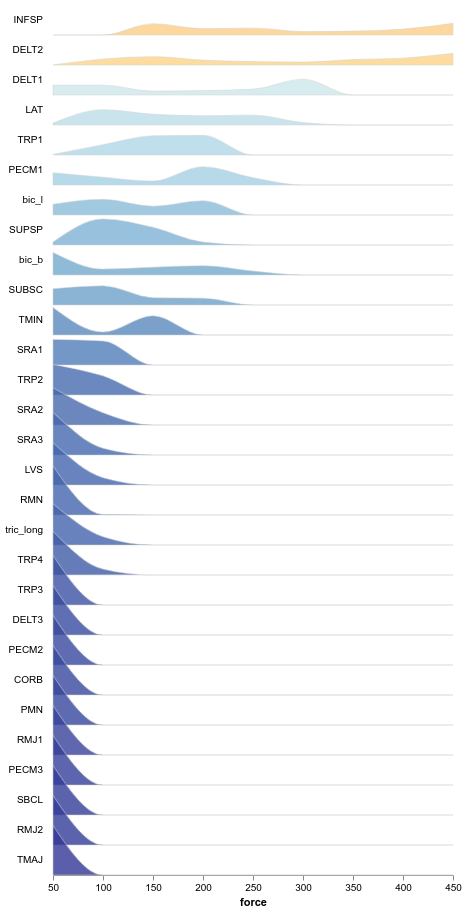

In [12]:
ridge_plot(
    act_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=act_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

## $\sum$activation

In [13]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,718.819903
1,AimQF12H2_1,aimq,0,2,12,1,0.01,592.425415
2,AimQF12H2_1,aimq,0,2,12,1,0.02,551.365705
3,AimQF12H2_1,aimq,0,2,12,1,0.03,575.656201
4,AimQF12H2_1,aimq,0,2,12,1,0.04,716.593768


In [14]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value              \
index                                                  0.00        0.01   
filename    participant men height mass n_trial                           
AimQF12H2_1 0           0   2      12   1        718.819903  592.425415   
AimQF12H2_2 0           0   2      12   2        839.144931  738.331368   
AimQF12H2_3 0           0   2      12   3        509.444649  402.857362   
AimQF6H2_1  0           0   2      6    1        730.850649  733.009993   
AimQF6H2_2  0           0   2      6    2        730.179835  661.904267   

                                                                          \
index                                                  0.02         0.03   
filename    participant men height mass n_trial                            
AimQF12H2_1 0           0   2      12   1        551.365705   575.656201   
AimQF12H2_2 0           0   2      12   2        562.613894   478.044743   
AimQF12H2_3 0           0   2      12   3        396.257602   387.331342   
AimQF6H2_1  0           0   2      6    1        738.391231  1128.778025   
AimQF6H2_2  0           0   2      6    2        621.831948   643.808847   

                                                                           \
index                                                   0.04         0.05   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1         716.593768   748.841771   
AimQF12H2_2 0           0   2      12   2         437.696157   511.426171   
AimQF12H2_3 0           0   2      12   3         456.696403   407.996200   
AimQF6H2_1  0           0   2      6    1        1340.653493  1365.680268   
AimQF6H2_2  0           0   2      6    2         959.392627  1231.783813   

                                                                           \
index                                                   0.06         0.07   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1         651.952935   948.688575   
AimQF12H2_2 0           0   2      12   2         598.808090   554.511587   
AimQF12H2_3 0           0   2      12   3         333.087885   281.470057   
AimQF6H2_1  0           0   2      6    1        1397.746729  1413.784133   
AimQF6H2_2  0           0   2      6    2        1362.197672  1523.104246   

                                                                           \
index                                                   0.08         0.09   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1        1805.003499  1939.895800   
AimQF12H2_2 0           0   2      12   2         998.273150  2110.587204   
AimQF12H2_3 0           0   2      12   3        1592.584634  2383.008040   
AimQF6H2_1  0           0   2      6    1        1376.610371  1359.349069   
AimQF6H2_2  0           0   2      6    2        1534.526081  1440.285875   

                                                 ...               \
index                                            ...         0.91   
filename    participant men height mass n_trial  ...                
AimQF12H2_1 0           0   2      12   1        ...  1937.536834   
AimQF12H2_2 0           0   2      12   2        ...  2624.098335   
AimQF12H2_3 0           0   2      12   3        ...  1368.901314   
AimQF6H2_1  0           0   2      6    1        ...  1497.557256   
AimQF6H2_2  0           0   2      6    2        ...  2093.856748   

                                                                           \
index                                                   0.92         0.93   
filename    participant men height mass n_trial                             
AimQF12H2_1 0           0   2      12   1        1553.026777  1500.813241   
AimQF12H2_2 0           0   2      12   2        2550.580866  2097.428000   
AimQF12H2_3 0           0   2      12   3        1394.2

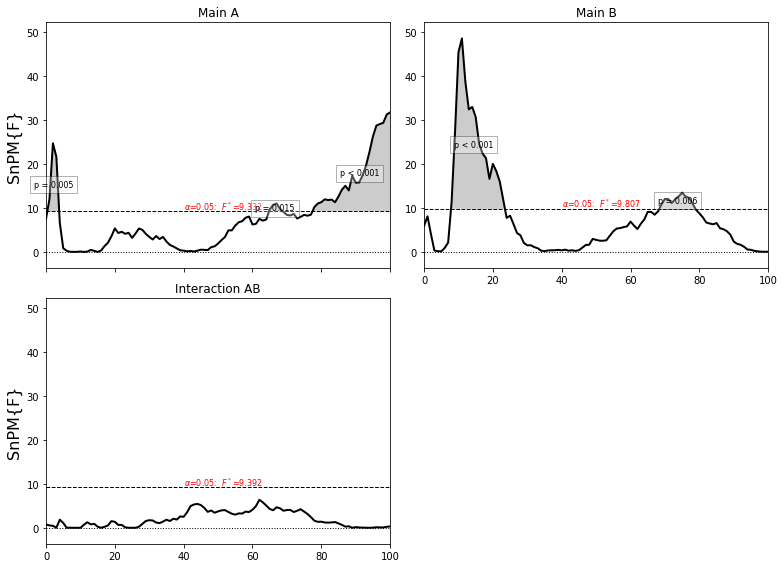

In [15]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [16]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.005,0.00396371,0.0378201
1,main sex,0.0146667,0.642026,0.680007
2,main sex,0,0.767136,0.990099
3,main mass,0,0.0775962,0.232731
4,main mass,0.006,0.676819,0.780951


In [17]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [18]:
base = alt.Chart(sum_act.query("participant != @blacklist")).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

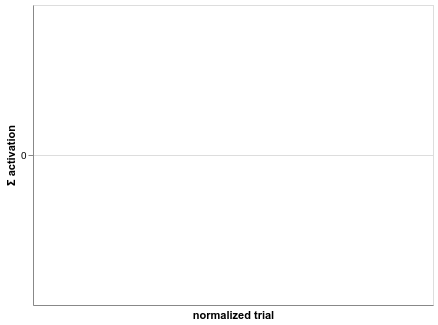

In [19]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

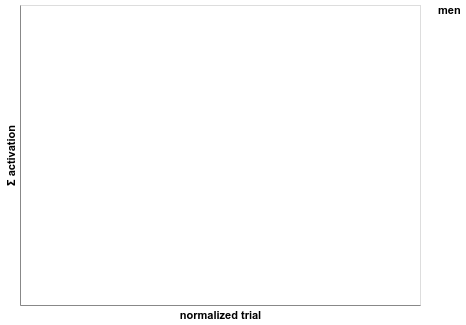

In [20]:
mu.mark_line(opacity=0.3).encode(
    alt.Color("men:N", scale=men_scale), alt.Detail("filename"), alt.Tooltip("filename")
)

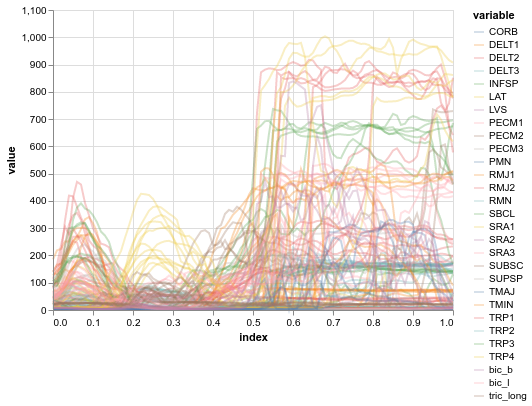

In [21]:
alt.Chart(act_melt.query('participant == "verc"')).mark_line(opacity=0.3).encode(
    alt.X("index:Q"),
    alt.Y("value:Q"),
    alt.Color("variable:N"),
    alt.Detail("filename"),
    alt.Tooltip("variable"),
)

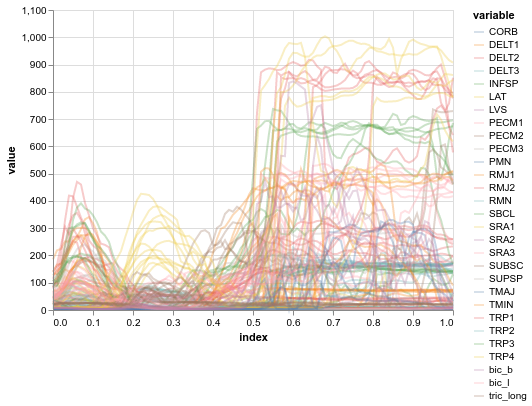

In [22]:
alt.Chart(act_melt.query('participant == "verc"')).mark_line(opacity=0.3).encode(
    alt.X("index:Q"),
    alt.Y("value:Q"),
    alt.Color("variable:N"),
    alt.Detail("filename"),
    alt.Tooltip("variable"),
)

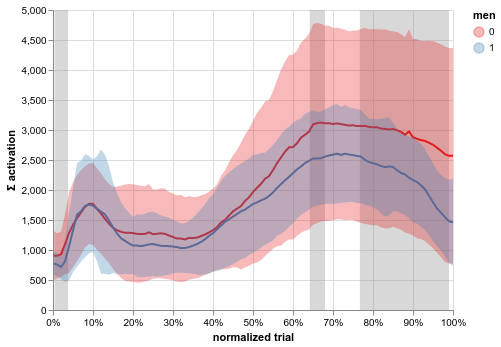

In [23]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

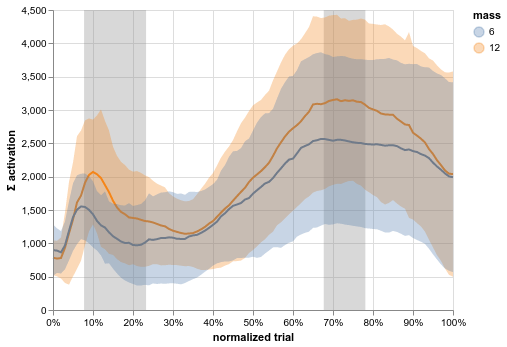

In [24]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

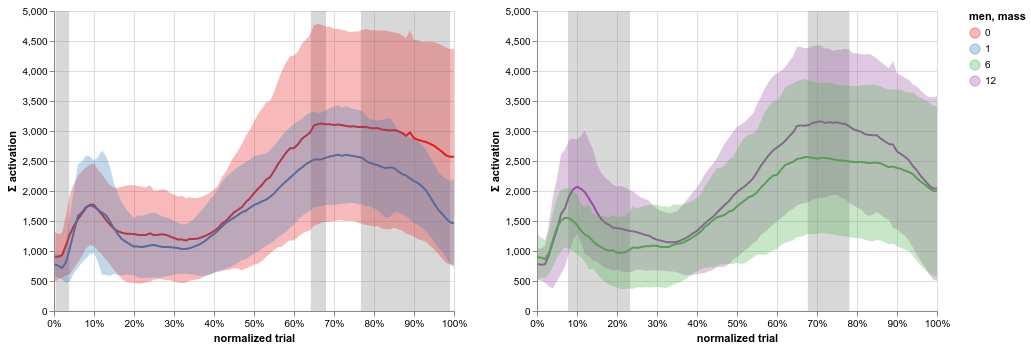

In [25]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

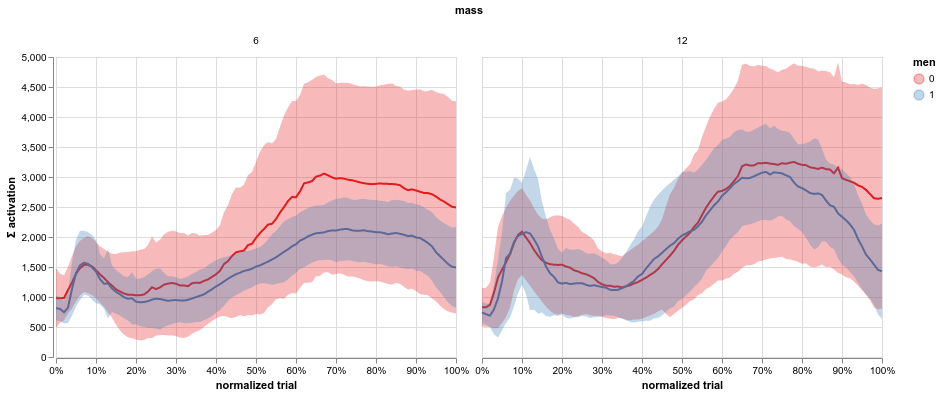

In [26]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## ECDF

### ECDF on activations

In [27]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [28]:
target_col_shape = 100

y = (
    act_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                      \
ecdf                                             0.000341  0.010242  0.020143   
filename    participant men height mass n_trial                                 
VerCF6H2_3  34          0   2      6    3        0.322015  0.666811  0.805402   
VerCF6H2_2  34          0   2      6    2        0.291041  0.646107  0.764059   
VerCF12H2_3 34          0   2      12   3        0.392840  0.638727  0.715254   
VerCF12H2_1 34          0   2      12   1        0.314423  0.568609  0.644439   
VerCF6H2_1  34          0   2      6    1        0.286976  0.663627  0.753746   

                                                                               \
ecdf                                             0.030044  0.039945  0.049846   
filename    participant men height mass n_trial                                 
VerCF6H2_3  34          0   2      6    3        0.863574  0.932212  0.988287   
VerCF6H2_2  34          0   2      6    2        0.854126  0.961814  1.029719   
VerCF12H2_3 34          0   2      12   3        0.800346  0.868706  0.931229   
VerCF12H2_1 34          0   2      12   1        0.702173  0.778348  0.864108   
VerCF6H2_1  34          0   2      6    1        0.851173  0.901751  1.006449   

                                                                               \
ecdf                                             0.059747  0.069648  0.079549   
filename    participant men height mass n_trial                                 
VerCF6H2_3  34          0   2      6    3        1.058571  1.136932  1.236328   
VerCF6H2_2  34          0   2      6    2        1.129837  1.196210  1.287522   
VerCF12H2_3 34          0   2      12   3        1.005731  1.121799  1.272839   
VerCF12H2_1 34          0   2      12   1        0.945971  1.040327  1.170400   
VerCF6H2_1  34          0   2      6    1        1.067585  1.125697  1.171887   

                                                           ...              \
ecdf                                             0.089450  ...    0.901332   
filename    participant men height mass n_trial            ...               
VerCF6H2_3  34          0   2      6    3        1.328333  ...  269.308631   
VerCF6H2_2  34          0   2      6    2        1.364950  ...  265.343975   
VerCF12H2_3 34          0   2      12   3        1.411694  ...  296.841334   
VerCF12H2_1 34          0   2      12   1        1.302534  ...  347.330696   
VerCF6H2_1  34          0   2      6    1        1.249083  ...  263.267971   

                                                                         \
ecdf                                               0.911233    0.921133   
filename    participant men height mass n_trial                           
VerCF6H2_3  34          0   2      6    3        307.714911  398.283212   
VerCF6H2_2  34          0   2      6    2        284.879372  306.756186   
VerCF12H2_3 34          0   2      12   3        312.400659  373.690724   
VerCF12H2_1 34          0   2      12   1        424.846276  454.784229   
VerCF6H2_1  34          0   2      6    1        291.723109  352.205045   

                                                                         \
ecdf                                               0.931034    0.940935   
filename    participant men height mass n_trial                           
VerCF6H2_3  34          0   2      6    3        436.836697  472.619347   
VerCF6H2_2  34          0   2      6    2        377.581171  441.172109   
VerCF12H2_3 34          0   2      12   3        449.776135  482.901919   
VerCF12H2_1 34          0   2      12   1        470.664674  486.009709   
VerCF6H2_1  34          0   2      6    1        438.307110  458.736042   

                                                                         \
ecdf                                               0.950836    0.960737   
filename    participant men height mass n_trial                           
VerCF6H2_3  34          0   2      6    3        508.

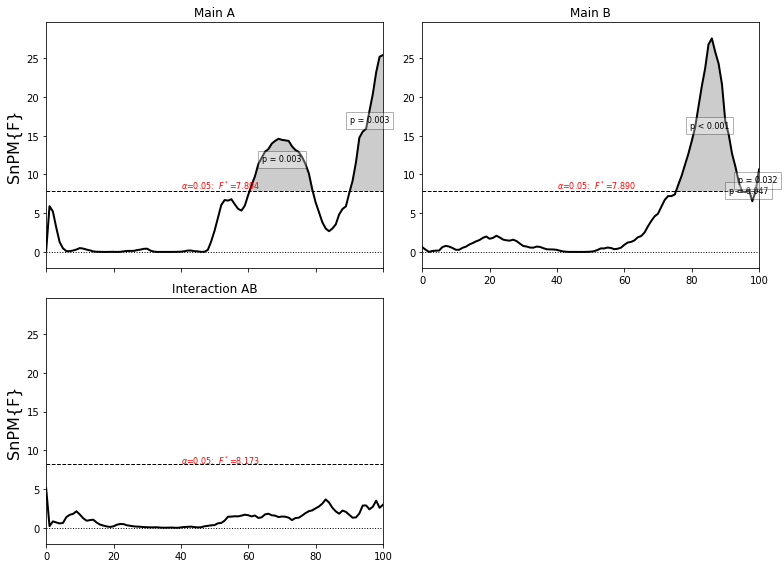

In [29]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [30]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.00333333,0.598167,0.783454
1,main sex,0.00333333,0.892889,0.990099
2,main mass,0.000333333,0.746337,0.939758
3,main mass,0.0466667,0.95523,0.961445
4,main mass,0.0316667,0.980377,0.990099


In [31]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [41]:
base = alt.Chart(y.stack().reset_index()).encode(
    alt.X("ecdf", axis=alt.Axis(format="%"), title="ecdf")
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

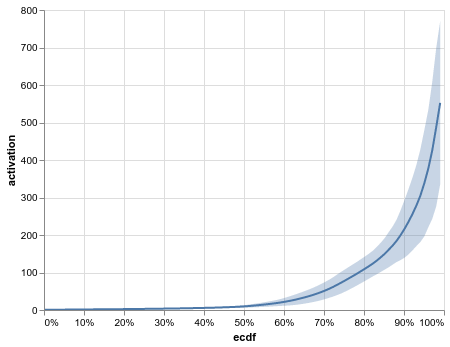

In [42]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

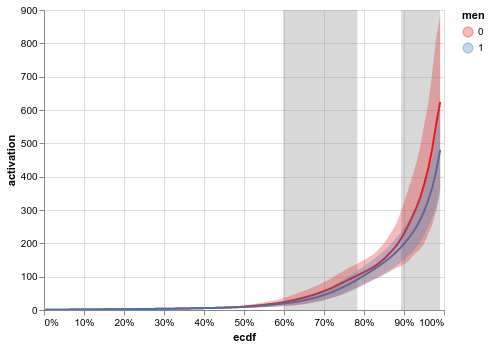

In [43]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

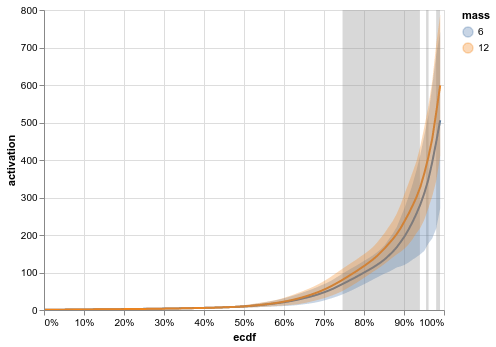

In [44]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

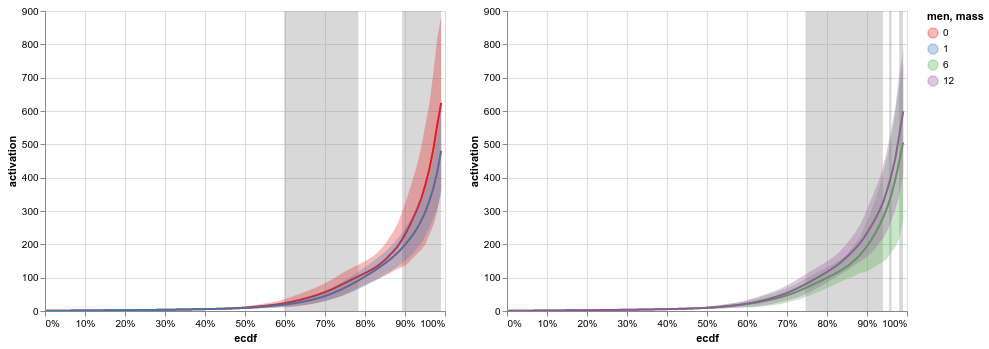

In [45]:
(
    c.transform_filter('datum.effect == "main sex"')
    + (mu + sigma).encode(alt.Color("men:N", scale=men_scale))
    | c.transform_filter('datum.effect == "main mass"')
    + (mu + sigma).encode(alt.Color("mass:N"))
).resolve_scale(x="shared", y="shared")

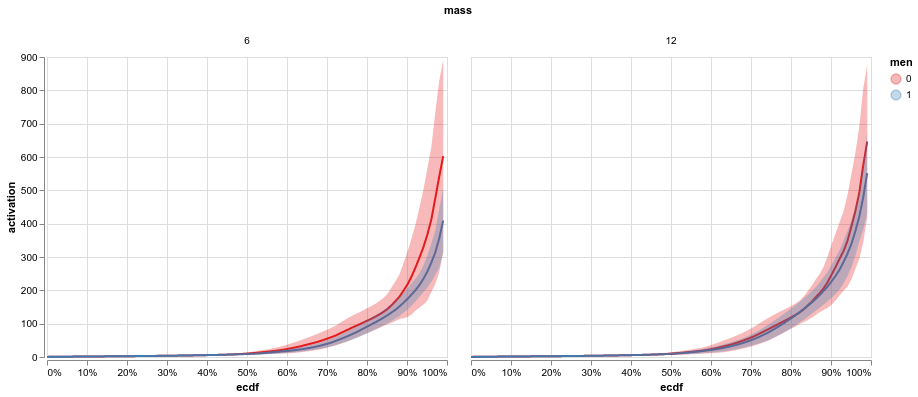

In [46]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## $\sum\sum\text{activations}$

In [38]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,mass,n_trial,value
0,AimQF12H2_1,aimq,0,2,12,1,150400.072240
1,AimQF12H2_2,aimq,0,2,12,2,141248.853327
2,AimQF12H2_3,aimq,0,2,12,3,134371.847651
3,AimQF6H2_1,aimq,0,2,6,1,143006.493601
4,AimQF6H2_2,aimq,0,2,6,2,210778.534066


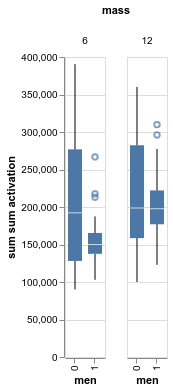

In [39]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("mass"))

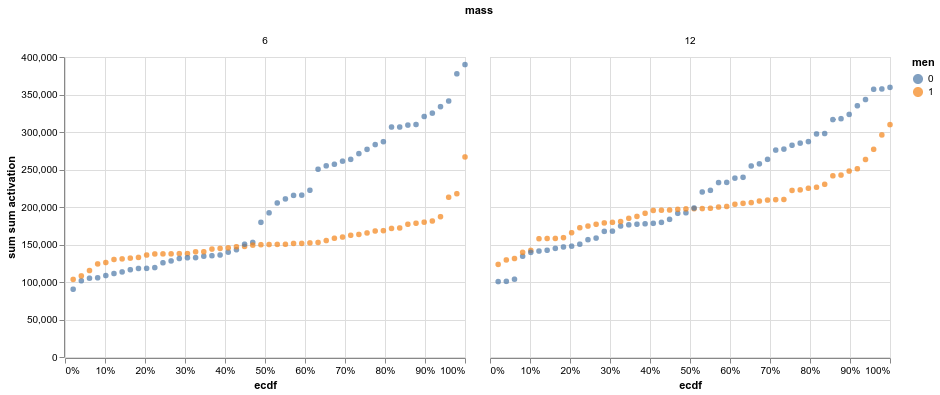

In [40]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >